<a href="https://colab.research.google.com/github/ddiimmaa31/-/blob/main/Forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Выгрузка данных

In [ ]:
! gdown --id 16pqv9WgZNcokO50na4R4gWvn7v9m-mX7

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=16pqv9WgZNcokO50na4R4gWvn7v9m-mX7
To: /content/bitcoin.zip
100% 24.5k/24.5k [00:00<00:00, 43.6MB/s]


In [ ]:
! gdown --id 1mK-L2GYCWPH4Vse_BojQ1-mrNEPf_kUu

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1mK-L2GYCWPH4Vse_BojQ1-mrNEPf_kUu
To: /content/Прошлые данные - Фьючерс на золото.csv
100% 58.6k/58.6k [00:00<00:00, 68.2MB/s]


In [ ]:
! gdown --id 1hTgNXLgXtnUue-WshjCK5tMjek4tqsOu

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1hTgNXLgXtnUue-WshjCK5tMjek4tqsOu
To: /content/Прошлые данные - AAPL.csv
100% 49.4k/49.4k [00:00<00:00, 66.9MB/s]


In [ ]:
! unzip /content/bitcoin.zip

Archive:  /content/bitcoin.zip
  inflating: bitcoin.xlsx            


In [ ]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error



In [ ]:
#pip install pmdarima

## Bitcoin

### Предобработка данных

In [ ]:
btc_df = pd.read_excel('bitcoin.xlsx', parse_dates=True, index_col='Дата')


In [ ]:
btc_df

,Значение
Дата,
2022-02-02,37526.38570
2022-02-01,38685.39579
2022-01-31,38480.80832
2022-01-30,37638.36669
2022-01-29,38272.76089
...,...
2019-02-05,3466.36000
2019-02-04,3459.15000
2019-02-03,3464.01000


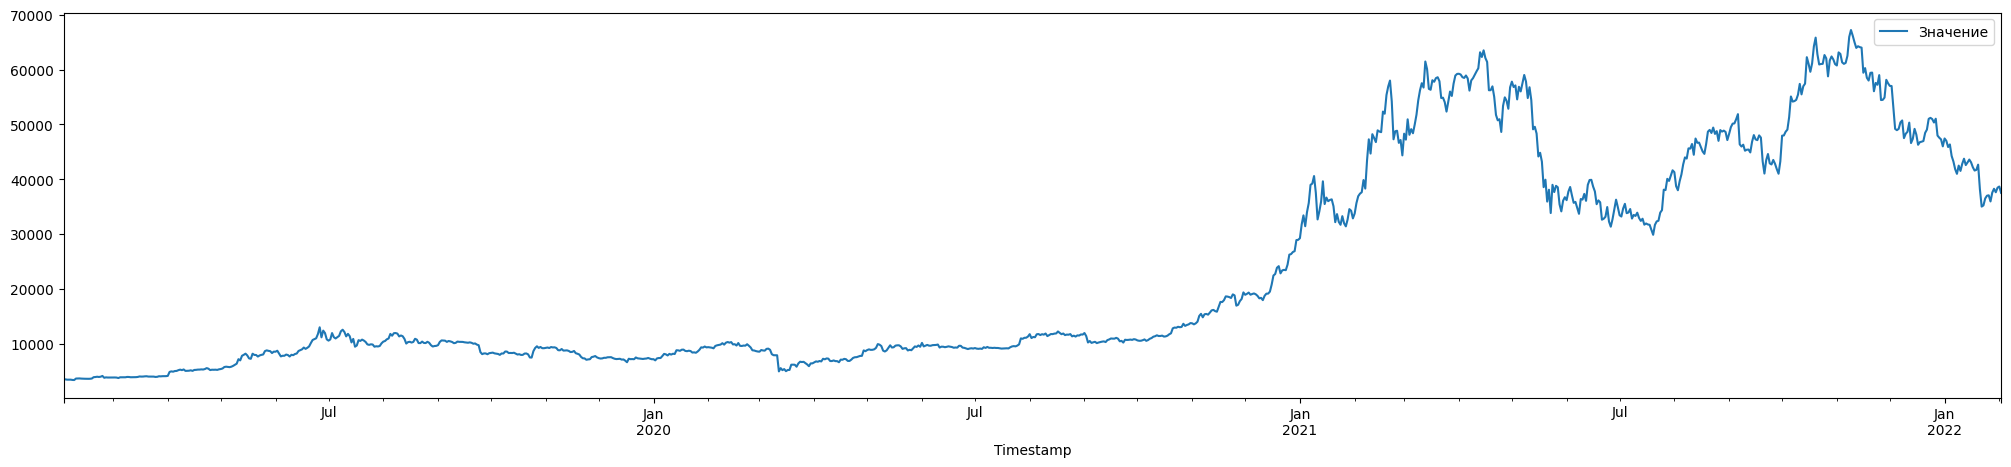

In [ ]:
btc_df.index.names=['Timestamp']
btc_df = btc_df.sort_index()

btc_df.plot(figsize=(25,5));

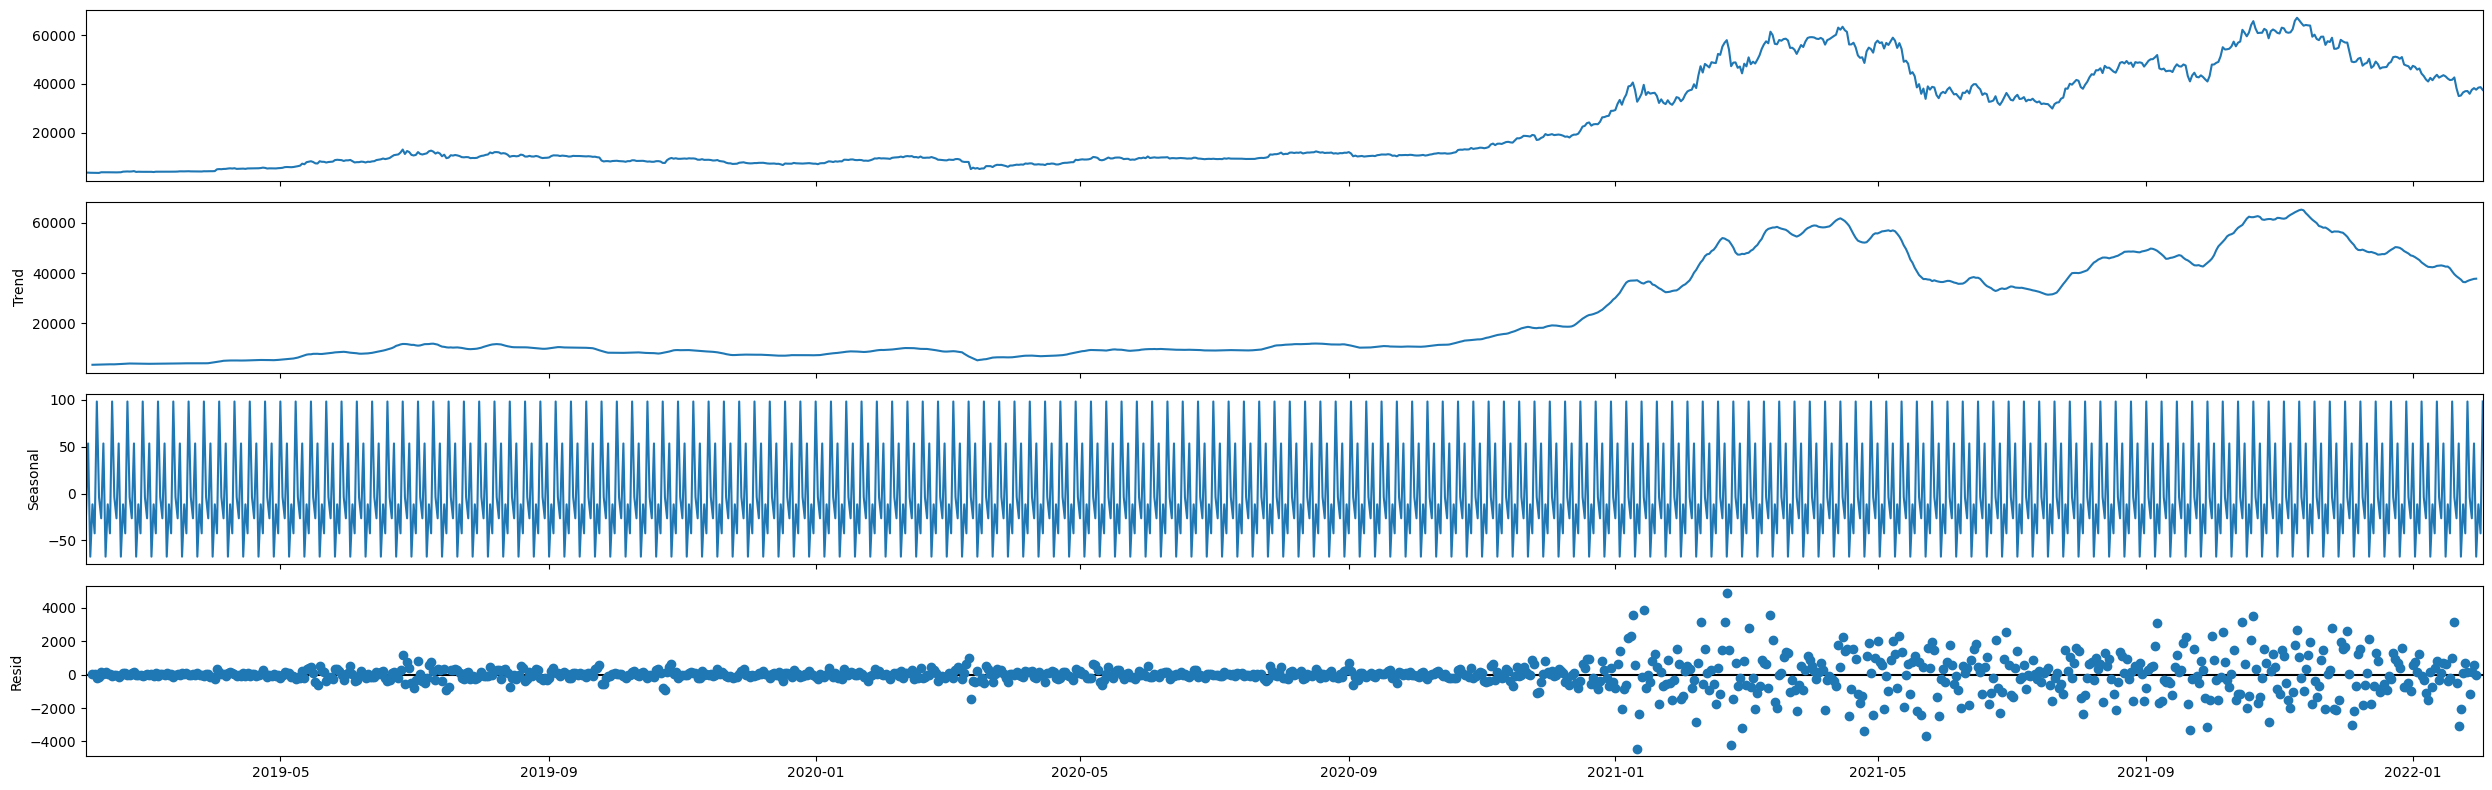

In [ ]:
res = sm.tsa.seasonal_decompose(btc_df)
plt.rc("figure", figsize=(25,8))
resplot = res.plot()

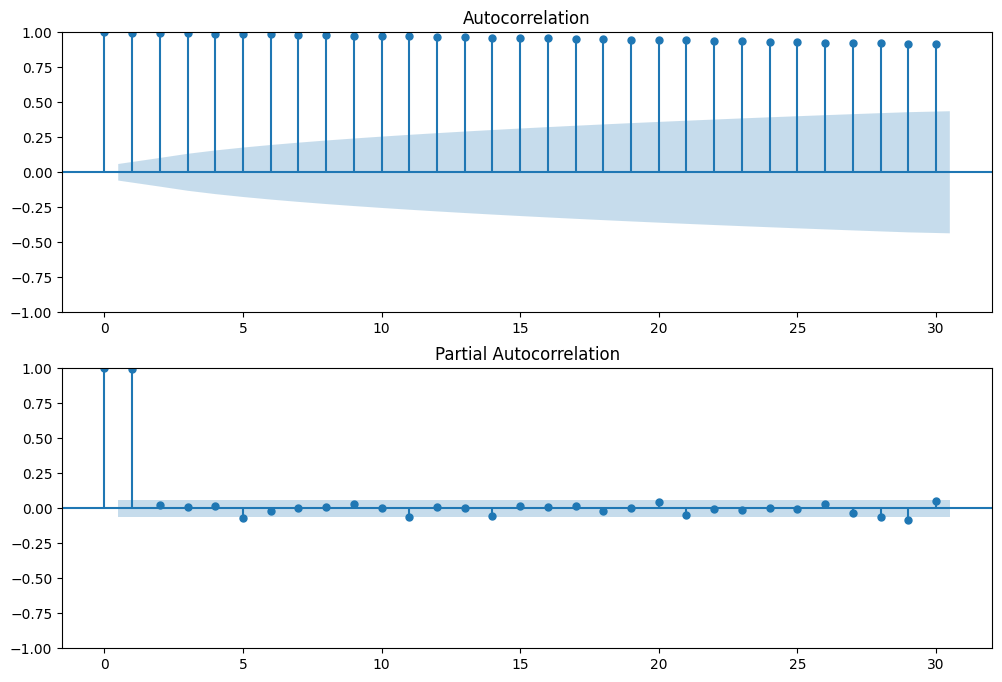

In [ ]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(btc_df.values.squeeze(), lags=30, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(btc_df, lags=30, ax=ax2)

### ARIMA

In [ ]:
#from pmdarima.arima import auto_arima

# Подготовка данных
train_data_ar_btc = btc_df[300:1050]
test_data_ar_btc = btc_df[1050:]

# Подбор параметров
# model = auto_arima(train_data_ar_btc, seasonal=False)
# print(model.order)  # Вывод оптимальных значений параметров

In [ ]:
model = ARIMA(train_data_ar_btc, order=(3, 3, 3))  # Параметры модели (p, d, q)
model_fit = model.fit()
#print(model_fit.summary())


future_periods = 48
forecast_ar_btc = model_fit.forecast(steps=future_periods)
#forecast = model_fit.predict(test_data)

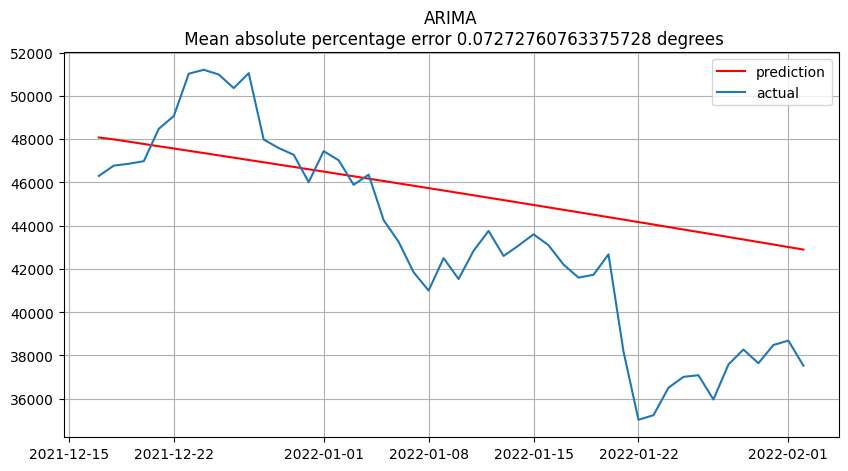

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(forecast_ar_btc,"r", label="prediction")
plt.plot(test_data_ar_btc, label="actual")
plt.grid(True)
plt.legend(loc="best")
plt.title(f"ARIMA\n Mean absolute percentage error {mean_absolute_percentage_error(forecast_ar_btc, test_data_ar_btc)} degrees");

In [ ]:
combined = np.column_stack((test_data_ar_btc, forecast_ar_btc))
btc_ar_traid = pd.DataFrame(combined, columns=['price', 'predict'])

# Задаем проценты для стоп-лосса и тейк-профита
stop_loss_percent = 0.8
take_profit_percent = 1.6

# Функция для проверки достижения стоп-лосса или тейк-профита
def check_position(data):
  forecast_price = data["predict"]
  actual_price = data["price"]

  stop_loss_price = forecast_price - (forecast_price * stop_loss_percent / 100)
  take_profit_price = forecast_price + (forecast_price * take_profit_percent / 100)

  if actual_price <= stop_loss_price:
      return "Стоп-лосс достигнут"
  elif actual_price >= take_profit_price:
      return "Тейк-профит достигнут"
  else:
      return "Позиция закрыта без достижения стоп-лосса или тейк-профита"

# Применяем функцию к каждой строке датасета и создаем новый столбец
btc_ar_traid["position"] = btc_ar_traid.apply(check_position, axis=1)


value_counts_ar_btc = btc_ar_traid['position'].value_counts()
print(value_counts_ar_btc)

Стоп-лосс достигнут                                           35
Тейк-профит достигнут                                         10
Позиция закрыта без достижения стоп-лосса или тейк-профита     3
Name: position, dtype: int64


### Exponential Smoothing

In [ ]:
from statsmodels.tsa.api import ExponentialSmoothing

In [ ]:
train_data_holt_btc = btc_df[300:950]
test_data_holt_btc = btc_df[950:]

In [ ]:
model = ExponentialSmoothing(train_data_holt_btc, trend='add', seasonal='add', seasonal_periods=30)
model_fit = model.fit()

future_predictions_holt_btc = model_fit.forecast(148)


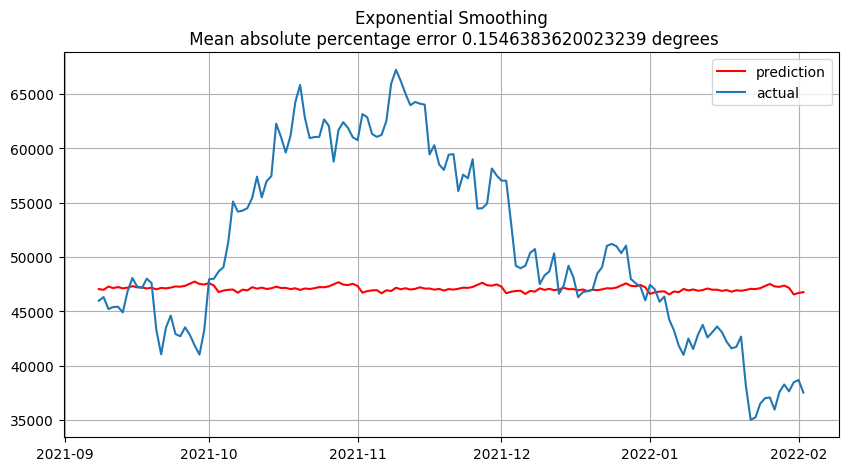

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(future_predictions_holt_btc,"r", label="prediction")
plt.plot(test_data_holt_btc, label="actual")
plt.grid(True)
plt.legend(loc="best")
plt.title(f"Exponential Smoothing\n Mean absolute percentage error {mean_absolute_percentage_error(future_predictions_holt_btc, test_data_holt_btc)} degrees");

In [ ]:
combined = np.column_stack((test_data_holt_btc, future_predictions_holt_btc))
btc_holt_traid = pd.DataFrame(combined, columns=['price', 'predict'])

# Задаем проценты для стоп-лосса и тейк-профита
stop_loss_percent = 0.8
take_profit_percent = 1.6

# Функция для проверки достижения стоп-лосса или тейк-профита
def check_position(data):
  forecast_price = data["predict"]
  actual_price = data["price"]

  stop_loss_price = forecast_price - (forecast_price * stop_loss_percent / 100)
  take_profit_price = forecast_price + (forecast_price * take_profit_percent / 100)

  if actual_price <= stop_loss_price:
      return "Стоп-лосс достигнут"
  elif actual_price >= take_profit_price:
      return "Тейк-профит достигнут"
  else:
      return "Позиция закрыта без достижения стоп-лосса или тейк-профита"

# Применяем функцию к каждой строке датасета и создаем новый столбец
btc_holt_traid["position"] = btc_holt_traid.apply(check_position, axis=1)


value_counts_holt_btc = btc_holt_traid['position'].value_counts()
print(value_counts_holt_btc)

Тейк-профит достигнут                                         81
Стоп-лосс достигнут                                           51
Позиция закрыта без достижения стоп-лосса или тейк-профита    16
Name: position, dtype: int64


### Линейная регрессия


In [ ]:
btc_df['Значение'].shift(1)

Timestamp
2019-02-01            NaN
2019-02-02     3487.95000
2019-02-03     3521.06000
2019-02-04     3464.01000
2019-02-05     3459.15000
                 ...     
2022-01-29    37577.72734
2022-01-30    38272.76089
2022-01-31    37638.36669
2022-02-01    38480.80832
2022-02-02    38685.39579
Name: Значение, Length: 1098, dtype: float64

In [ ]:
for i in range(1,8):
  btc_df[f"lag{i}"] = btc_df['Значение'].shift(i)

In [ ]:
btc_df.head()

,Значение,lag1,lag2,lag3,lag4,lag5,lag6,lag7
Timestamp,,,,,,,,
2019-02-01,3487.95,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-02-02,3521.06,3487.95,NaN,NaN,NaN,NaN,NaN,NaN
2019-02-03,3464.01,3521.06,3487.95,NaN,NaN,NaN,NaN,NaN
2019-02-04,3459.15,3464.01,3521.06,3487.95,NaN,NaN,NaN,NaN
2019-02-05,3466.36,3459.15,3464.01,3521.06,3487.95,NaN,NaN,NaN


In [ ]:
btc_df.dropna(inplace=True)
btc_df

,Значение,lag1,lag2,lag3,lag4,lag5,lag6,lag7
Timestamp,,,,,,,,
2019-02-08,3666.78000,3399.47000,3413.77000,3466.36000,3459.15000,3464.01000,3521.06000,3487.95000
2019-02-09,3671.20000,3666.78000,3399.47000,3413.77000,3466.36000,3459.15000,3464.01000,3521.06000
2019-02-10,3690.19000,3671.20000,3666.78000,3399.47000,3413.77000,3466.36000,3459.15000,3464.01000
2019-02-11,3659.45000,3690.19000,3671.20000,3666.78000,3399.47000,3413.77000,3466.36000,3459.15000
2019-02-12,3653.53000,3659.45000,3690.19000,3671.20000,3666.78000,3399.47000,3413.77000,3466.36000
...,...,...,...,...,...,...,...,...
2022-01-29,38272.76089,37577.72734,35963.23924,37083.25123,37007.91477,36505.44883,35236.40116,35024.65712
2022-01-30,37638.36669,38272.76089,37577.72734,35963.23924,37083.25123,37007.91477,36505.44883,35236.40116
2022-01-31,38480.80832,37638.36669,38272.76089,37577.72734,35963.23924,37083.25123,37007.91477,36505.44883


In [ ]:
train_lin_btc = btc_df.loc['02.07.2020':'09.12.2021']
test_lin_btc = btc_df.loc['10.12.2021':'02.02.2022']

train_lin_btc.shape, test_lin_btc.shape

((584, 8), (114, 8))

In [ ]:
X_train = train_lin_btc.drop('Значение', axis=1)
y_train = train_lin_btc['Значение']

X_test = test_lin_btc.drop('Значение', axis=1)
y_test = test_lin_btc['Значение']

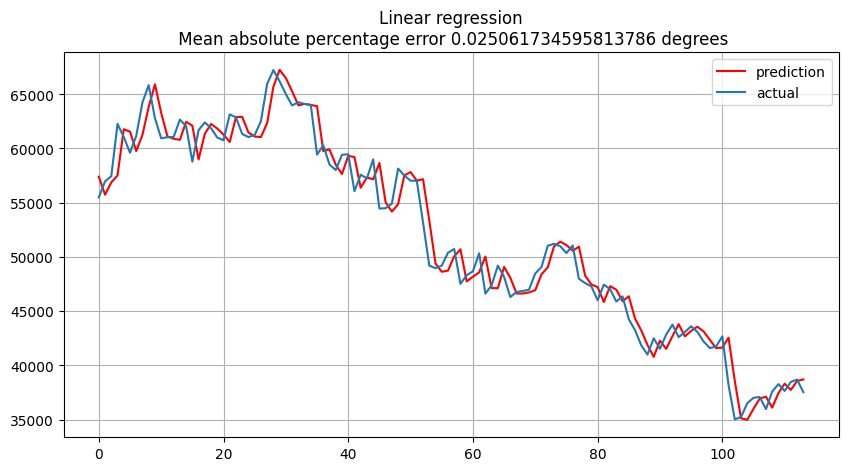

In [ ]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)

preds_lin_btc = lr.predict(X_test)

plt.figure(figsize=(10,5))
plt.plot(preds_lin_btc,"r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.grid(True)
plt.legend(loc="best")
plt.title(f"Linear regression\n Mean absolute percentage error {mean_absolute_percentage_error(preds_lin_btc, y_test)} degrees");

In [ ]:
combined = np.column_stack((y_test, preds_lin_btc))
btc_lin_traid = pd.DataFrame(combined, columns=['price', 'predict'])

# Задаем проценты для стоп-лосса и тейк-профита
stop_loss_percent = 0.8
take_profit_percent = 1.6

# Функция для проверки достижения стоп-лосса или тейк-профита
def check_position(data):
  forecast_price = data["predict"]
  actual_price = data["price"]

  stop_loss_price = forecast_price - (forecast_price * stop_loss_percent / 100)
  take_profit_price = forecast_price + (forecast_price * take_profit_percent / 100)

  if actual_price <= stop_loss_price:
      return "Стоп-лосс достигнут"
  elif actual_price >= take_profit_price:
      return "Тейк-профит достигнут"
  else:
      return "Позиция закрыта без достижения стоп-лосса или тейк-профита"

# Применяем функцию к каждой строке датасета и создаем новый столбец
btc_lin_traid["position"] = btc_lin_traid.apply(check_position, axis=1)


value_counts_lin_btc = btc_lin_traid['position'].value_counts()
print(value_counts_lin_btc)

Стоп-лосс достигнут                                           46
Позиция закрыта без достижения стоп-лосса или тейк-профита    37
Тейк-профит достигнут                                         31
Name: position, dtype: int64


### Деревья

In [ ]:
train_forest_btc = btc_df.loc['02.07.2020':'09.12.2021']
test_forest_btc = btc_df.loc['10.12.2021':'02.02.2022']

train_forest_btc.shape, test_forest_btc.shape

((584, 8), (114, 8))

In [ ]:
X_train = train_forest_btc.drop('Значение', axis=1)
y_train = train_forest_btc['Значение']

X_test = test_forest_btc.drop('Значение', axis=1)
y_test = test_forest_btc['Значение']

In [ ]:
# Создание и обучение модели случайного леса
model = RandomForestRegressor(n_estimators=1000, max_depth=100)
model.fit(X_train, y_train)

RandomForestRegressor(max_depth=100, n_estimators=1000)

In [ ]:
# Прогнозирование на тестовом наборе
y_pred_forest_btc = model.predict(X_test)

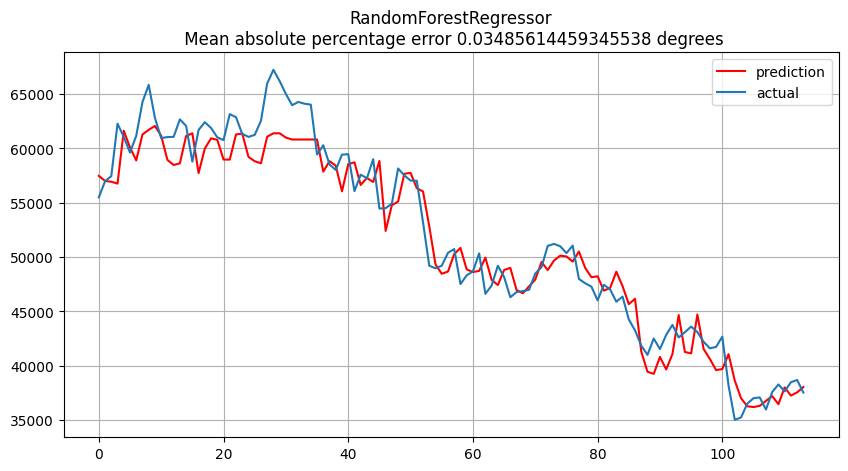

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(y_pred_forest_btc,"r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.grid(True)
plt.legend(loc="best")
plt.title(f"RandomForestRegressor\n Mean absolute percentage error {mean_absolute_percentage_error(y_pred_forest_btc, y_test)} degrees");

In [ ]:
combined = np.column_stack((y_test, y_pred_forest_btc))
btc_forest_traid = pd.DataFrame(combined, columns=['price', 'predict'])

# Задаем проценты для стоп-лосса и тейк-профита
stop_loss_percent = 0.8
take_profit_percent = 1.6

# Функция для проверки достижения стоп-лосса или тейк-профита
def check_position(data):
  forecast_price = data["predict"]
  actual_price = data["price"]

  stop_loss_price = forecast_price - (forecast_price * stop_loss_percent / 100)
  take_profit_price = forecast_price + (forecast_price * take_profit_percent / 100)

  if actual_price <= stop_loss_price:
      return "Стоп-лосс достигнут"
  elif actual_price >= take_profit_price:
      return "Тейк-профит достигнут"
  else:
      return "Позиция закрыта без достижения стоп-лосса или тейк-профита"

# Применяем функцию к каждой строке датасета и создаем новый столбец
btc_forest_traid["position"] = btc_forest_traid.apply(check_position, axis=1)


value_counts_forest_btc = btc_forest_traid['position'].value_counts()
print(value_counts_forest_btc)

Тейк-профит достигнут                                         52
Стоп-лосс достигнут                                           32
Позиция закрыта без достижения стоп-лосса или тейк-профита    30
Name: position, dtype: int64


### Сравнение результатов

In [ ]:
btc_srav = pd.DataFrame({'ARIMA': [10, 35, 3],
                   'Exponentia_Smoothing': [81, 51, 16],
                   'Linear_regression': [46, 31, 37],
                   'Random_Forest_Regressor': [53, 33, 30]}, index=['Тейк-профит_достигнут', 'Стоп-лосс_достигнут', 'Дней в позиции'])
btc_srav = btc_srav.T

btc_srav = btc_srav.assign(ROI=(btc_srav['Тейк-профит_достигнут']*16).sub(btc_srav['Стоп-лосс_достигнут']*8))

In [ ]:
btc_srav

,Тейк-профит_достигнут,Стоп-лосс_достигнут,Дней в позиции,ROI
ARIMA,10,35,3,-120
Exponentia_Smoothing,81,51,16,888
Linear_regression,46,31,37,488
Random_Forest_Regressor,53,33,30,584


from matplotlib import pyplot as plt
btc_srav['Тейк-профит_достигнут'].plot(kind='hist', bins=20, title='Тейк-профит_достигнут')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
btc_srav['Стоп-лосс_достигнут'].plot(kind='hist', bins=20, title='Стоп-лосс_достигнут')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
btc_srav['Дней в позиции'].plot(kind='hist', bins=20, title='Дней в позиции')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
btc_srav['ROI'].plot(kind='hist', bins=20, title='ROI')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
btc_srav.plot(kind='scatter', x='Тейк-профит_достигнут', y='Стоп-лосс_достигнут', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
btc_srav.plot(kind='scatter', x='Стоп-лосс_достигнут', y='Дней в позиции', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
btc_srav.plot(kind='scatter', x='Дней в позиции', y='ROI', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
btc_srav['Тейк-профит_достигнут'].plot(kind='line', figsize=(8, 4), title='Тейк-профит_достигнут')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
btc_srav['Стоп-лосс_достигнут'].plot(kind='line', figsize=(8, 4), title='Стоп-лосс_достигнут')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
btc_srav['Дней в позиции'].plot(kind='line', figsize=(8, 4), title='Дней в позиции')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
btc_srav['ROI'].plot(kind='line', figsize=(8, 4), title='ROI')
plt.gca().spines[['top', 'right']].set_visible(False)

## Apple

### Предобработка данных

In [ ]:
apple_df = pd.read_csv('Прошлые данные - AAPL.csv', parse_dates=True, index_col='Дата')

In [ ]:
#удаляем ненужные столбцы
apple_df = apple_df.drop(columns=['Откр.', 'Макс.', 'Мин.', 'Объём', 'Изм. %'])

#Избавляемся от запятых
for j in apple_df['Цена']:
    c = j.replace(',', '.')
    apple_df['Цена']=apple_df['Цена'].replace(j,c)

#преобразуем в тип float
apple_df['Цена'] = apple_df['Цена'].astype(float)


In [ ]:
apple_df

,Цена
Дата,
2022-02-02,175.84
2022-01-02,174.61
2022-01-31,174.78
2022-01-28,170.33
2022-01-27,159.22
...,...
2019-07-02,42.73
2019-06-02,43.56
2019-05-02,43.55


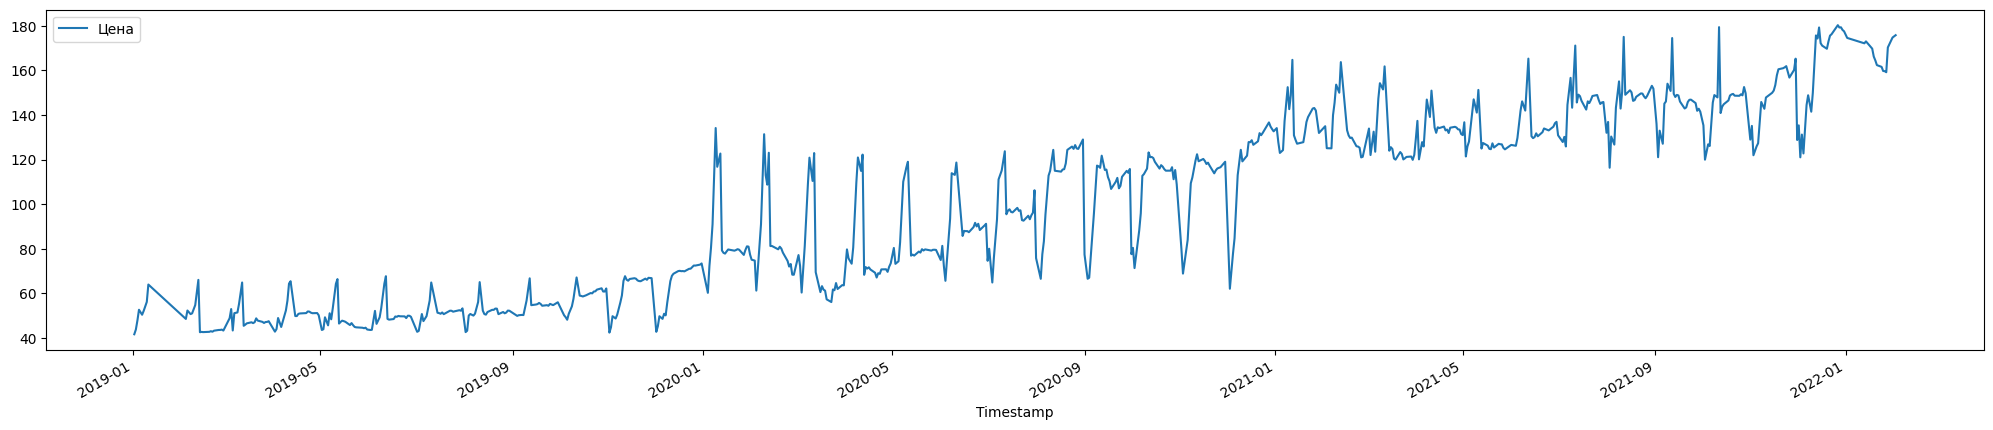

In [ ]:
apple_df.index.names=['Timestamp']
apple_df = apple_df.sort_index()
apple_df = apple_df.iloc[:750]

apple_df.plot(figsize=(25,5));

In [ ]:
apple_df

,Цена
Timestamp,
2019-01-02,41.63
2019-01-03,43.74
2019-01-04,47.81
2019-01-05,52.63
2019-01-07,50.39
...,...
2022-01-26,159.69
2022-01-27,159.22
2022-01-28,170.33


In [ ]:
apple_df = apple_df.asfreq('D')

In [ ]:
apple_df['Цена'] = apple_df['Цена'].fillna(method='ffill')


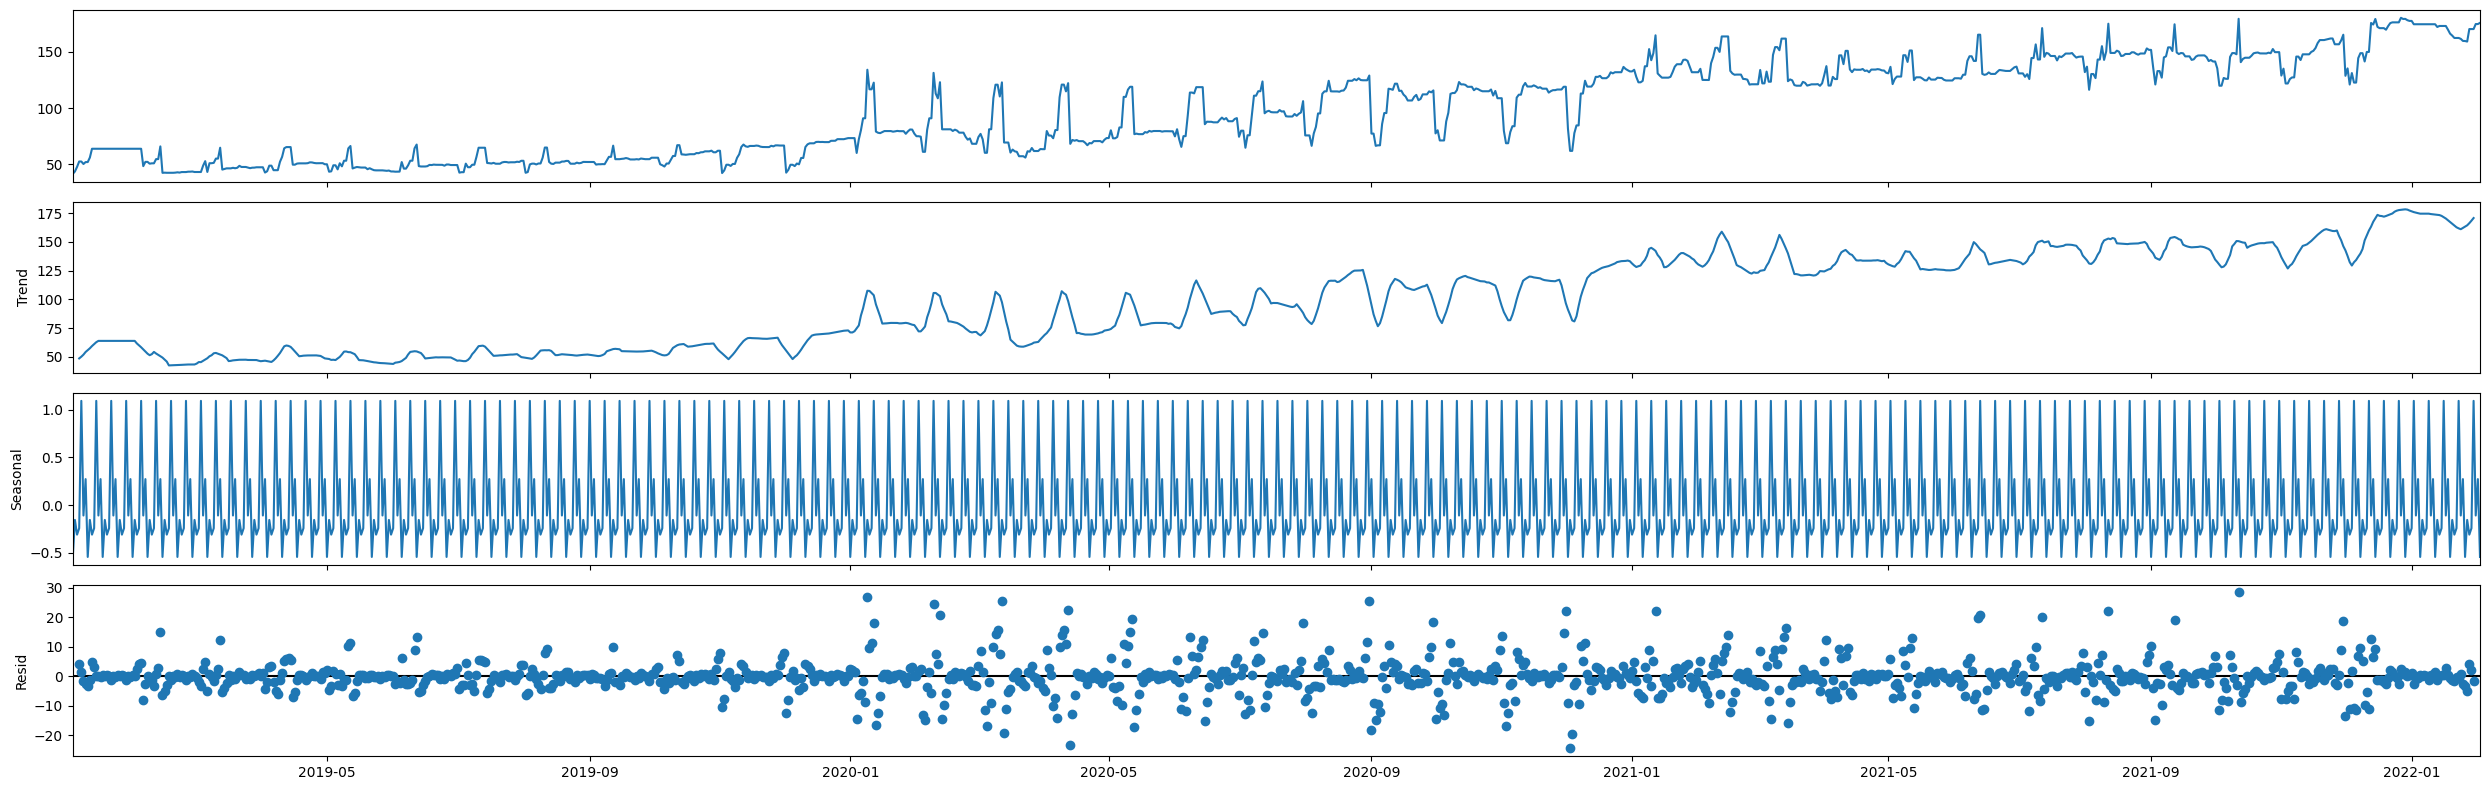

In [ ]:
res = sm.tsa.seasonal_decompose(apple_df)
plt.rc("figure", figsize=(25,8))
resplot = res.plot()

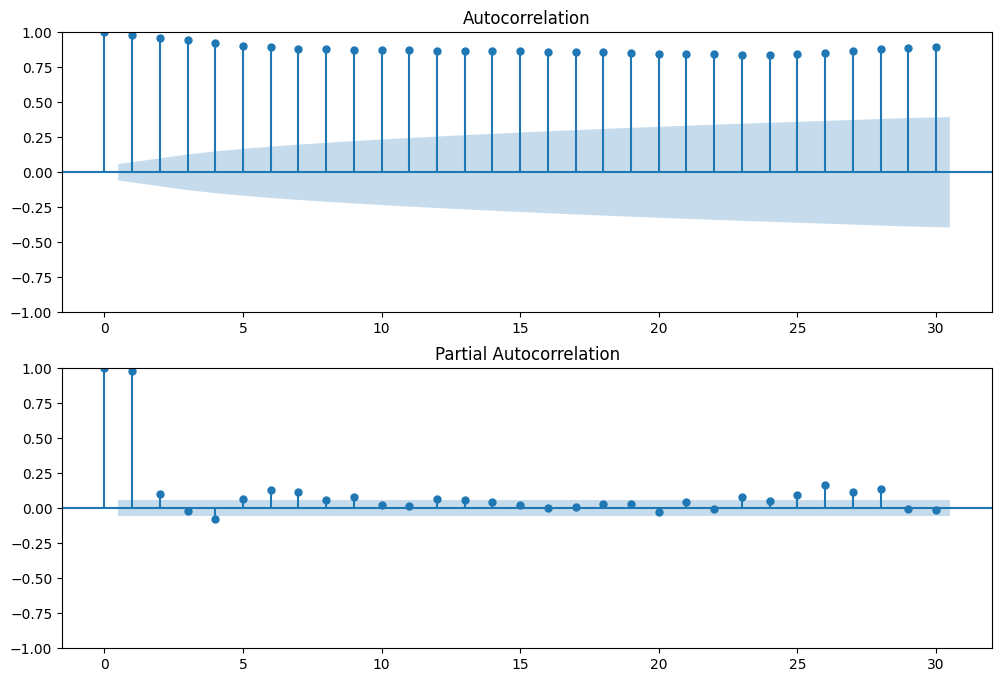

In [ ]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(apple_df.values.squeeze(), lags=30, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(apple_df, lags=30, ax=ax2)

In [ ]:
apple_df_1 = apple_df['Цена'].shift(1)
apple_df.dropna(inplace=True)
apple_df_1

Timestamp
2019-01-02       NaN
2019-01-03     41.63
2019-01-04     43.74
2019-01-05     47.81
2019-01-06     52.63
               ...  
2022-01-29    170.33
2022-01-30    170.33
2022-01-31    170.33
2022-02-01    174.78
2022-02-02    174.78
Freq: D, Name: Цена, Length: 1128, dtype: float64

### ARIMA

In [ ]:
# smoothed_apple = apple_df.ewm(alpha=0.9).mean()

In [ ]:
# Подготовка данных
train_ar_apple_data = apple_df[1000:1100]
test_ar_apple_data = apple_df[1100:]

# Подбор параметров
# model = auto_arima(train_data, seasonal=True)
# print(model.order)  # Вывод оптимальных значений параметров

In [ ]:
model = ARIMA(train_ar_apple_data, order=(2, 1, 2))  # Параметры модели (p, d, q)
model_fit = model.fit()
#print(model_fit.summary())


# future_periods = 10
forecast_ar_apple = model_fit.forecast(steps=28)
#forecast = model_fit.predict(test_data)

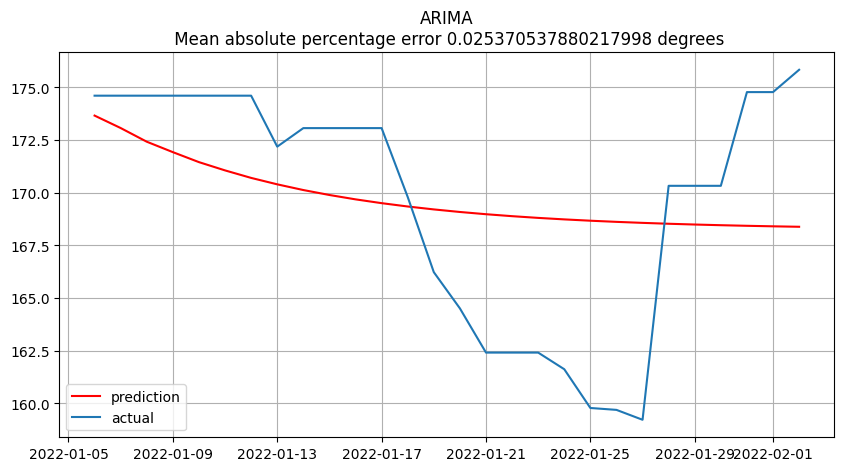

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(forecast_ar_apple,"r", label="prediction")
plt.plot(test_ar_apple_data, label="actual")
plt.grid(True)
plt.legend(loc="best")
plt.title(f"ARIMA\n Mean absolute percentage error {mean_absolute_percentage_error(forecast_ar_apple, test_ar_apple_data)} degrees");

In [ ]:
combined = np.column_stack((test_ar_apple_data, forecast_ar_apple))
apple_ar_traid = pd.DataFrame(combined, columns=['price', 'predict'])

# Задаем проценты для стоп-лосса и тейк-профита
stop_loss_percent = 0.5
take_profit_percent = 1


# Функция для проверки достижения стоп-лосса или тейк-профита
def check_position(data):
  forecast_price = data["predict"]
  actual_price = data["price"]

  stop_loss_price = forecast_price - (forecast_price * stop_loss_percent / 100)
  take_profit_price = forecast_price + (forecast_price * take_profit_percent / 100)

  if actual_price <= stop_loss_price:
      return "Стоп-лосс достигнут"
  elif actual_price >= take_profit_price:
      return "Тейк-профит достигнут"
  else:
      return "Позиция закрыта без достижения стоп-лосса или тейк-профита"

# Применяем функцию к каждой строке датасета и создаем новый столбец
apple_ar_traid["position"] = apple_ar_traid.apply(check_position, axis=1)


value_counts_ar_apple = apple_ar_traid['position'].value_counts()
print(value_counts_ar_apple)

Тейк-профит достигнут                                         16
Стоп-лосс достигнут                                            9
Позиция закрыта без достижения стоп-лосса или тейк-профита     3
Name: position, dtype: int64


### Exponential Smoothing

In [ ]:
# Подготовка данных
train_data_holt_apple = apple_df[:950]
test_data_holt_apple = apple_df[950:]

In [ ]:
model = ExponentialSmoothing(train_data_holt_apple, trend='add', seasonal='mul',seasonal_periods=7)
model_fit = model.fit()

future_pred_holt_apple = model_fit.forecast(178)

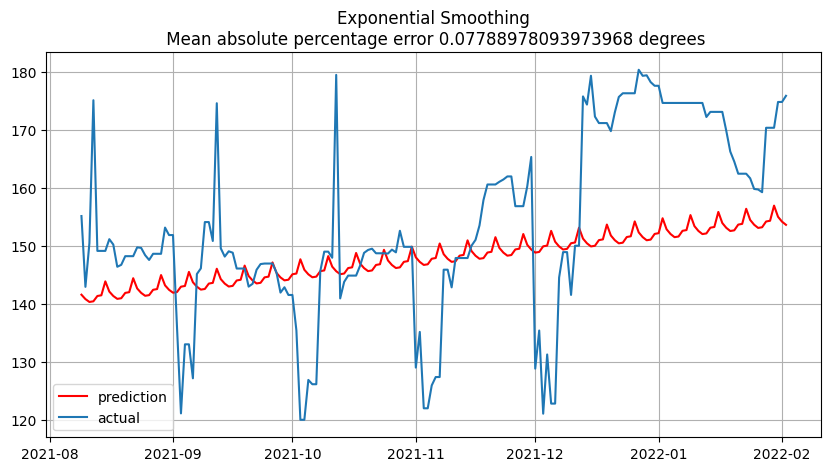

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(future_pred_holt_apple,"r", label="prediction")
plt.plot(test_data_holt_apple, label="actual")
plt.grid(True)
plt.legend(loc="best")
plt.title(f"Exponential Smoothing\n Mean absolute percentage error {mean_absolute_percentage_error(future_pred_holt_apple, test_data_holt_apple)} degrees");

In [ ]:
combined = np.column_stack((test_data_holt_apple, future_pred_holt_apple))
apple_holt_traid = pd.DataFrame(combined, columns=['price', 'predict'])

# Задаем проценты для стоп-лосса и тейк-профита
stop_loss_percent = 0.5
take_profit_percent = 1


# Функция для проверки достижения стоп-лосса или тейк-профита
def check_position(data):
  forecast_price = data["predict"]
  actual_price = data["price"]

  stop_loss_price = forecast_price - (forecast_price * stop_loss_percent / 100)
  take_profit_price = forecast_price + (forecast_price * take_profit_percent / 100)

  if actual_price <= stop_loss_price:
      return "Стоп-лосс достигнут"
  elif actual_price >= take_profit_price:
      return "Тейк-профит достигнут"
  else:
      return "Позиция закрыта без достижения стоп-лосса или тейк-профита"

# Применяем функцию к каждой строке датасета и создаем новый столбец
apple_holt_traid["position"] = apple_holt_traid.apply(check_position, axis=1)


value_counts_holt_apple = apple_holt_traid['position'].value_counts()
print(value_counts_holt_apple)

Тейк-профит достигнут                                         120
Стоп-лосс достигнут                                            41
Позиция закрыта без достижения стоп-лосса или тейк-профита     17
Name: position, dtype: int64


### Линейная регрессия

In [ ]:
apple_df['Цена'].shift(1)

Timestamp
2019-01-02       NaN
2019-01-03     41.63
2019-01-04     43.74
2019-01-05     47.81
2019-01-06     52.63
               ...  
2022-01-29    170.33
2022-01-30    170.33
2022-01-31    170.33
2022-02-01    174.78
2022-02-02    174.78
Freq: D, Name: Цена, Length: 1128, dtype: float64

In [ ]:
for i in range(1,8):
  apple_df[f"lag{i}"] = apple_df['Цена'].shift(i)

In [ ]:
apple_df.head()

,Цена,lag1,lag2,lag3,lag4,lag5,lag6,lag7
Timestamp,,,,,,,,
2019-01-02,41.63,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-03,43.74,41.63,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-04,47.81,43.74,41.63,NaN,NaN,NaN,NaN,NaN
2019-01-05,52.63,47.81,43.74,41.63,NaN,NaN,NaN,NaN
2019-01-06,52.63,52.63,47.81,43.74,41.63,NaN,NaN,NaN


In [ ]:
apple_df.dropna(inplace=True)
apple_df

,Цена,lag1,lag2,lag3,lag4,lag5,lag6,lag7
Timestamp,,,,,,,,
2019-01-09,52.11,52.11,50.39,52.63,52.63,47.81,43.74,41.63
2019-01-10,56.15,52.11,52.11,50.39,52.63,52.63,47.81,43.74
2019-01-11,63.95,56.15,52.11,52.11,50.39,52.63,52.63,47.81
2019-01-12,63.95,63.95,56.15,52.11,52.11,50.39,52.63,52.63
2019-01-13,63.95,63.95,63.95,56.15,52.11,52.11,50.39,52.63
...,...,...,...,...,...,...,...,...
2022-01-29,170.33,170.33,159.22,159.69,159.78,161.62,162.41,162.41
2022-01-30,170.33,170.33,170.33,159.22,159.69,159.78,161.62,162.41
2022-01-31,174.78,170.33,170.33,170.33,159.22,159.69,159.78,161.62


In [ ]:
train_apple_lin = apple_df.loc['01-09-2019':'02-08-2021']
test_apple_lin = apple_df.loc['03-08-2021':'02-02-2022']

train_apple_lin.shape, test_apple_lin.shape

((762, 8), (332, 8))

In [ ]:
X_train = train_apple_lin.drop('Цена', axis=1)
y_train = train_apple_lin['Цена']

X_test = test_apple_lin.drop('Цена', axis=1)
y_test = test_apple_lin['Цена']

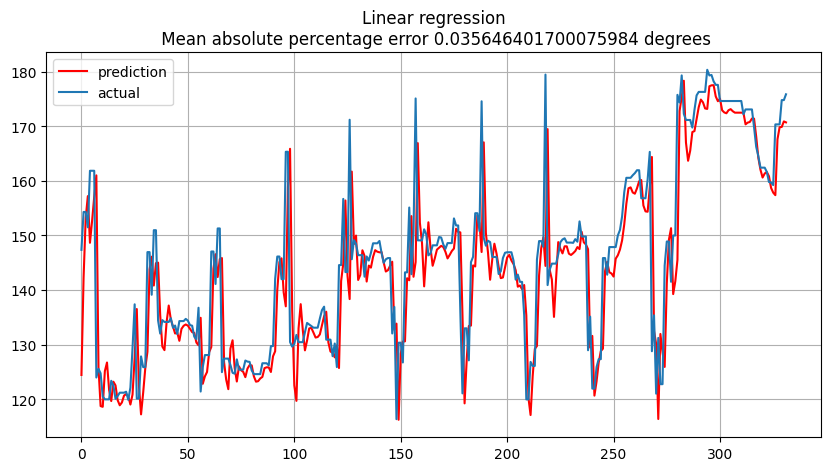

In [ ]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)

preds_apple_lin = lr.predict(X_test)

plt.figure(figsize=(10,5))
plt.plot(preds_apple_lin,"r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.grid(True)
plt.legend(loc="best")
plt.title(f"Linear regression\n Mean absolute percentage error {mean_absolute_percentage_error(preds_apple_lin, y_test)} degrees");

In [ ]:
combined = np.column_stack((y_test, preds_apple_lin))
apple_lin_traid = pd.DataFrame(combined, columns=['price', 'predict'])

# Задаем проценты для стоп-лосса и тейк-профита
stop_loss_percent = 0.5
take_profit_percent = 1


# Функция для проверки достижения стоп-лосса или тейк-профита
def check_position(data):
  forecast_price = data["predict"]
  actual_price = data["price"]

  stop_loss_price = forecast_price - (forecast_price * stop_loss_percent / 100)
  take_profit_price = forecast_price + (forecast_price * take_profit_percent / 100)

  if actual_price <= stop_loss_price:
      return "Стоп-лосс достигнут"
  elif actual_price >= take_profit_price:
      return "Тейк-профит достигнут"
  else:
      return "Позиция закрыта без достижения стоп-лосса или тейк-профита"

# Применяем функцию к каждой строке датасета и создаем новый столбец
apple_lin_traid["position"] = apple_lin_traid.apply(check_position, axis=1)


value_counts_lin_apple = apple_lin_traid['position'].value_counts()
print(value_counts_lin_apple)

Тейк-профит достигнут                                         173
Позиция закрыта без достижения стоп-лосса или тейк-профита     86
Стоп-лосс достигнут                                            73
Name: position, dtype: int64


### Деревья

In [ ]:
train_forest_apple = apple_df.loc['01-01-2020':'07-12-2021']
test_forest_apple = apple_df.loc['08-12-2021':'02-02-2022']

train_forest_apple.shape, test_forest_apple.shape

((559, 8), (175, 8))

In [ ]:
X_train = train_forest_apple.drop('Цена', axis=1)
y_train = train_forest_apple['Цена']

X_test = test_forest_apple.drop('Цена', axis=1)
y_test = test_forest_apple['Цена']

In [ ]:
# Создание и обучение модели случайного леса
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [ ]:
# Прогнозирование на тестовом наборе
pred_forest_apple = model.predict(X_test)

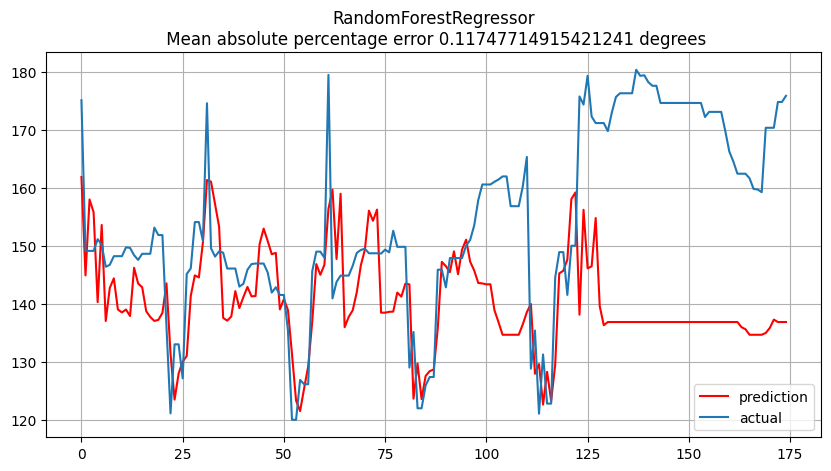

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(pred_forest_apple,"r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.grid(True)
plt.legend(loc="best")
plt.title(f"RandomForestRegressor\n Mean absolute percentage error {mean_absolute_percentage_error(pred_forest_apple, y_test)} degrees");

In [ ]:
combined = np.column_stack((y_test, pred_forest_apple))
apple_forest_traid = pd.DataFrame(combined, columns=['price', 'predict'])

# Задаем проценты для стоп-лосса и тейк-профита
stop_loss_percent = 0.5
take_profit_percent = 1


# Функция для проверки достижения стоп-лосса или тейк-профита
def check_position(data):
  forecast_price = data["predict"]
  actual_price = data["price"]

  stop_loss_price = forecast_price - (forecast_price * stop_loss_percent / 100)
  take_profit_price = forecast_price + (forecast_price * take_profit_percent / 100)

  if actual_price <= stop_loss_price:
      return "Стоп-лосс достигнут"
  elif actual_price >= take_profit_price:
      return "Тейк-профит достигнут"
  else:
      return "Позиция закрыта без достижения стоп-лосса или тейк-профита"

# Применяем функцию к каждой строке датасета и создаем новый столбец
apple_forest_traid["position"] = apple_forest_traid.apply(check_position, axis=1)


value_counts_forest_apple = apple_forest_traid['position'].value_counts()
print(value_counts_forest_apple)

Тейк-профит достигнут                                         128
Стоп-лосс достигнут                                            41
Позиция закрыта без достижения стоп-лосса или тейк-профита      6
Name: position, dtype: int64


### Сравнение результатов

In [ ]:
apple_srav = pd.DataFrame({'ARIMA': [16, 9, 3],
                   'Exponentia_Smoothing': [120, 41, 17],
                   'Linear_regression': [173, 73, 86],
                   'Random_Forest_Regressor': [128, 41, 6]}, index=['Тейк-профит_достигнут', 'Стоп-лосс_достигнут', 'Дней в позиции'])
apple_srav = apple_srav.T

apple_srav = apple_srav.assign(ROI=(apple_srav['Тейк-профит_достигнут']*10).sub(apple_srav['Стоп-лосс_достигнут']*5))

In [ ]:
apple_srav

,Тейк-профит_достигнут,Стоп-лосс_достигнут,Дней в позиции,ROI
ARIMA,16,9,3,115
Exponentia_Smoothing,120,41,17,995
Linear_regression,173,73,86,1365
Random_Forest_Regressor,128,41,6,1075


## Золото

### Предобработка данных

In [ ]:
gold_df = pd.read_csv('Прошлые данные - Фьючерс на золото.csv', parse_dates=True, index_col='Дата')

In [ ]:
#удаляем ненужные столбцы
gold_df = gold_df.drop(columns=['Откр.', 'Макс.', 'Мин.', 'Объём', 'Изм. %'])

#Избавляемся от запятых
for j in gold_df['Цена']:
    c = j.replace(',', '.')
    c = c[:1]+c[2:]
    gold_df['Цена']=gold_df['Цена'].replace(j,c)

#преобразуем в тип float
gold_df['Цена'] = gold_df['Цена'].astype(float)


gold_df = gold_df.iloc[:768] #удаляем ненужные строки

In [ ]:
gold_df

,Цена
Дата,
2022-02-02,1810.3
2022-01-02,1801.5
2022-01-31,1796.4
2022-01-28,1786.6
2022-01-27,1793.1
...,...
2019-02-19,1344.8
2019-02-18,1344.8
2019-02-15,1322.1


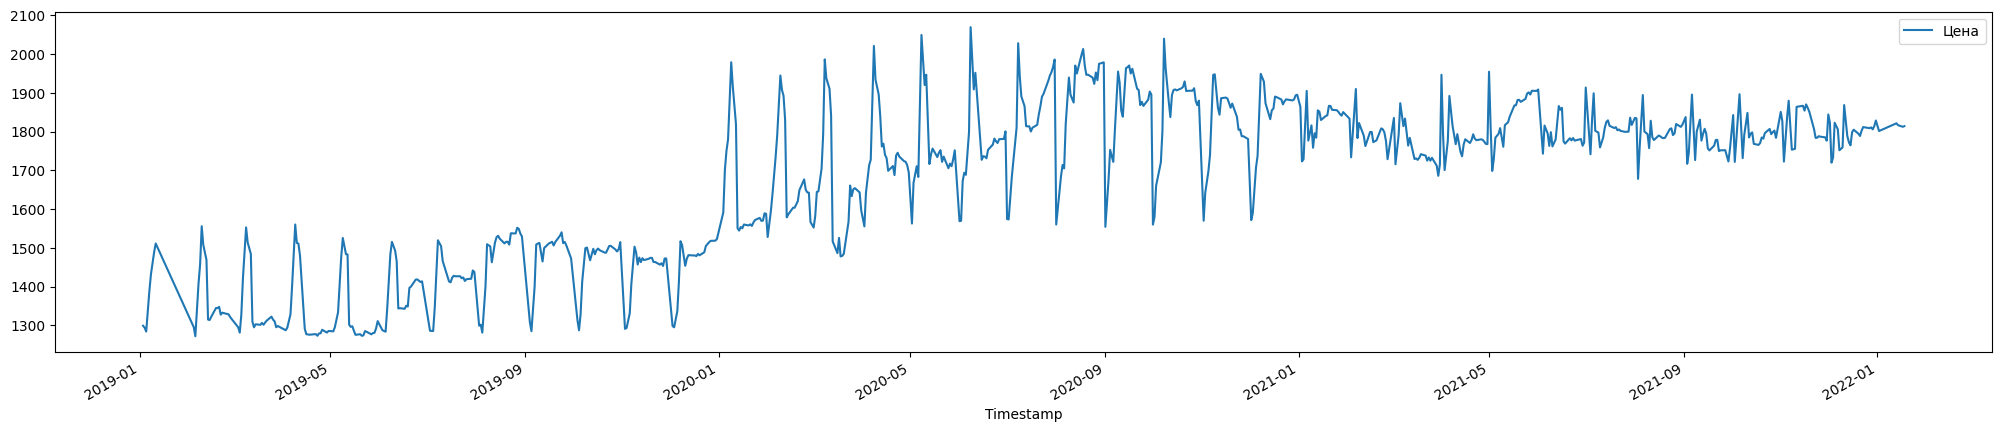

In [ ]:
gold_df.index.names=['Timestamp']
gold_df = gold_df.sort_index()
gold_df = gold_df.iloc[:750]

gold_df.plot(figsize=(25,5));

In [ ]:
gold_df

,Цена
Timestamp,
2019-01-03,1299.2
2019-01-04,1294.2
2019-01-05,1284.2
2019-01-07,1389.3
2019-01-08,1432.4
...,...
2022-01-02,1801.5
2022-01-13,1821.4
2022-01-14,1816.5


In [ ]:
gold_df = gold_df.asfreq('D')

In [ ]:
gold_df['Цена'] = gold_df['Цена'].fillna(method='ffill')


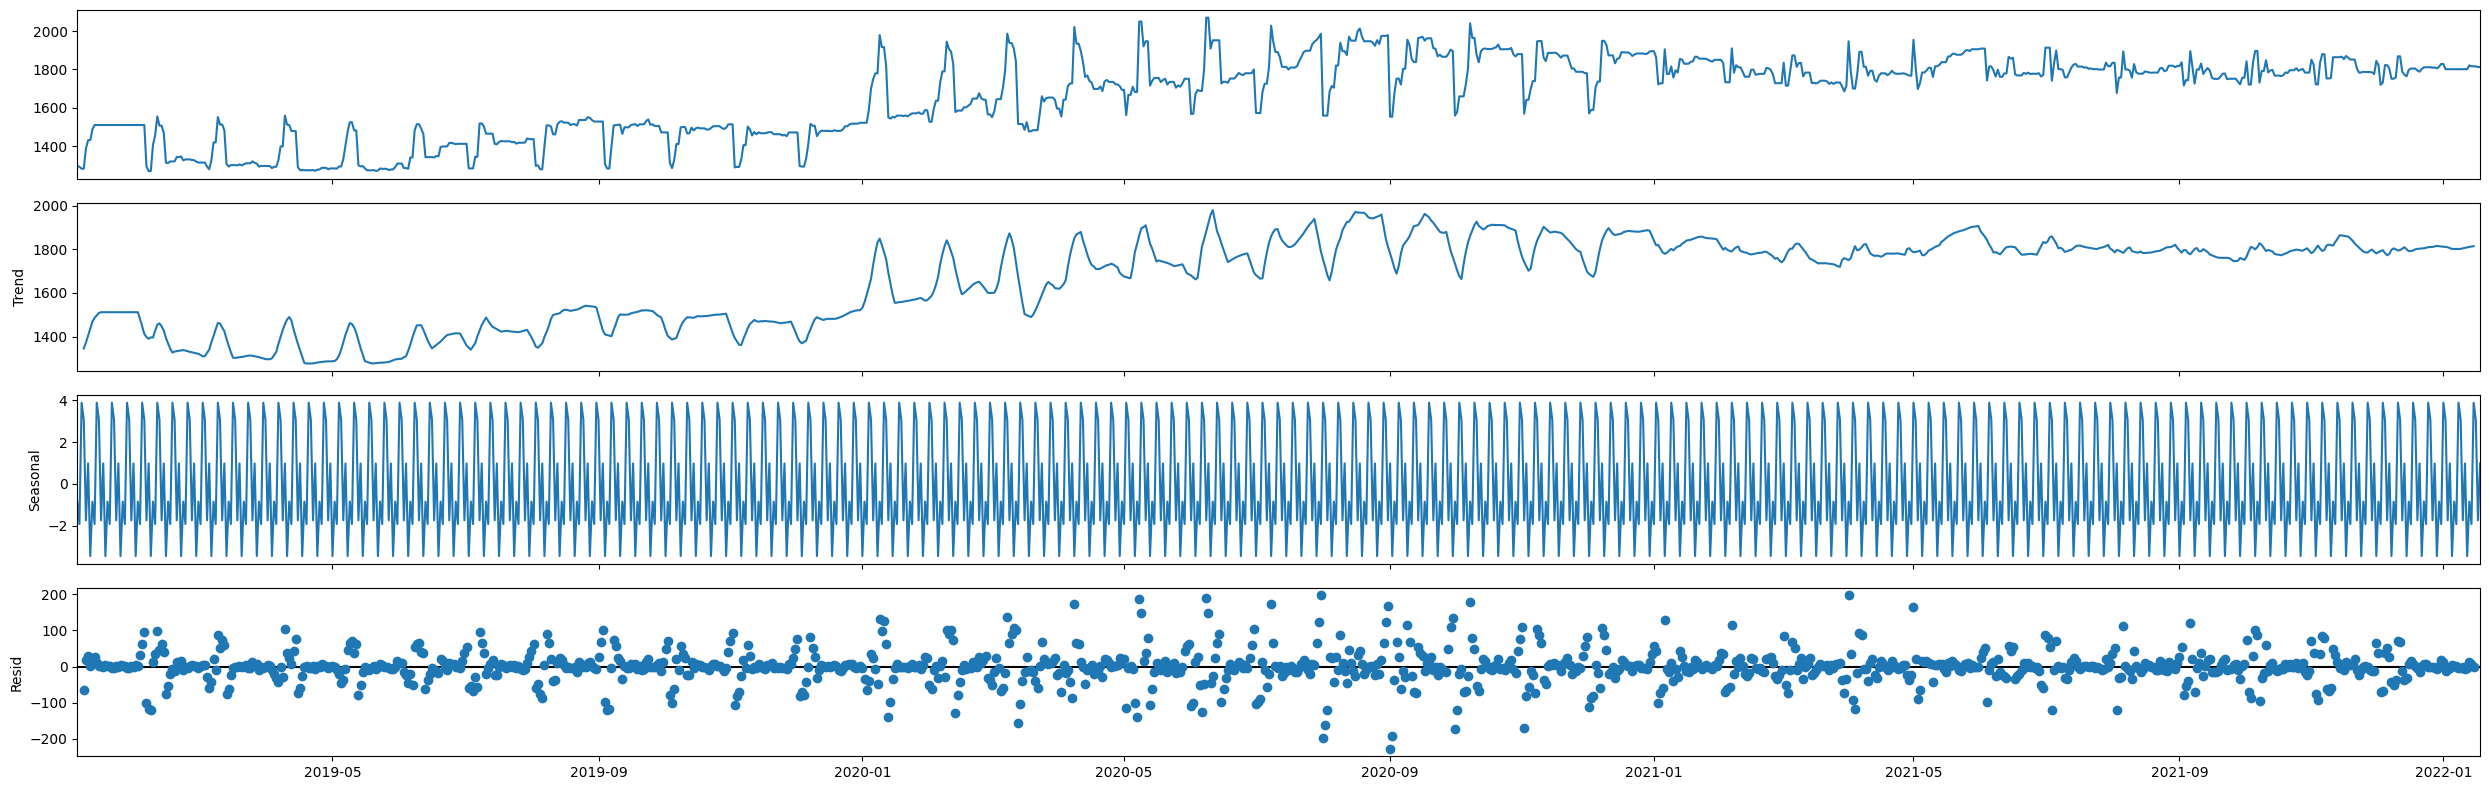

In [ ]:
res_g = sm.tsa.seasonal_decompose(gold_df)
plt.rc("figure", figsize=(25,8))
resplot = res_g.plot()

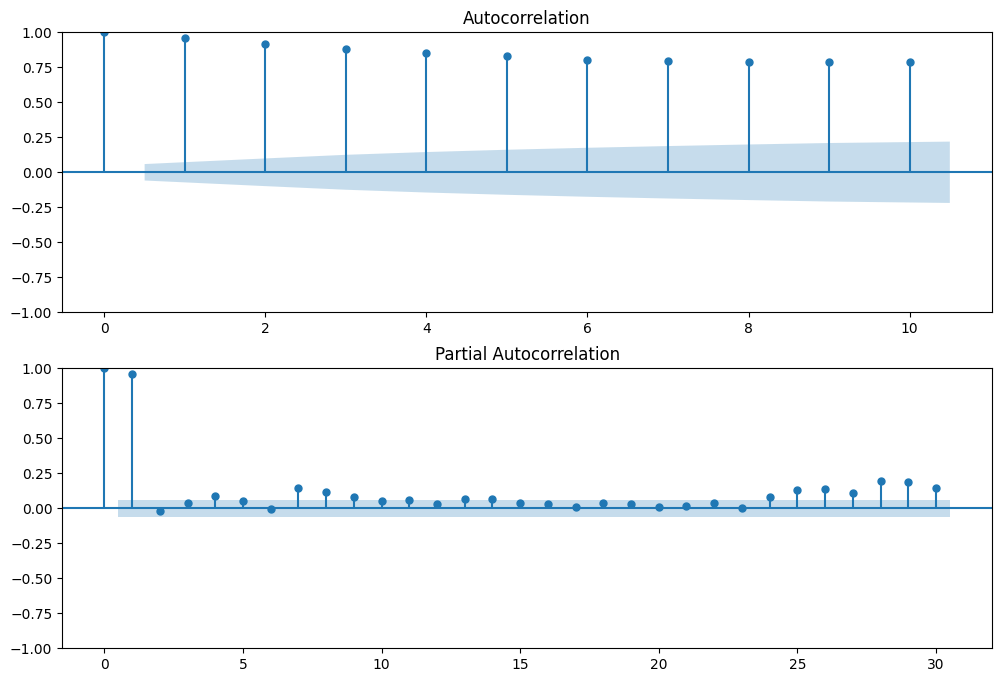

In [ ]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(gold_df.values.squeeze(), lags=10, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(gold_df, lags=30, ax=ax2)

In [ ]:
gold_df

,Цена
Timestamp,
2019-01-03,1299.2
2019-01-04,1294.2
2019-01-05,1284.2
2019-01-06,1284.2
2019-01-07,1389.3
...,...
2022-01-14,1816.5
2022-01-15,1816.5
2022-01-16,1816.5


### ARIMA

In [ ]:
# Подготовка данных
train_data_ar_g = gold_df[:900]
test_data_ar_g = gold_df[900:]

# Подбор параметров
# model_ar_g = auto_arima(train_data_ar_g, seasonal=False)
# print(model_ar_g.order)  # Вывод оптимальных значений параметров

In [ ]:
model_ar_g = ARIMA(train_data_ar_g, order=(3, 1, 2))  # Параметры модели (p, d, q)
model_fit_ar_g = model_ar_g.fit()
#print(model_fit.summary())


future_periods = 212
forecast_ar_g = model_fit_ar_g.forecast(steps=future_periods)
#forecast = model_fit.predict(test_data)

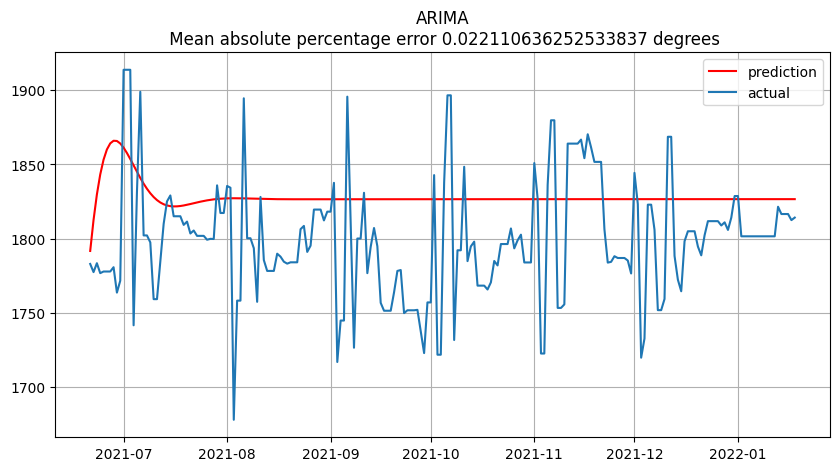

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(forecast_ar_g,"r", label="prediction")
plt.plot(test_data_ar_g, label="actual")
plt.grid(True)
plt.legend(loc="best")
plt.title(f"ARIMA\n Mean absolute percentage error {mean_absolute_percentage_error(forecast_ar_g, test_data_ar_g)} degrees");

In [ ]:
combined = np.column_stack((test_data_ar_g, forecast_ar_g))
gold_ar_traid = pd.DataFrame(combined, columns=['price', 'predict'])

# Задаем проценты для стоп-лосса и тейк-профита
stop_loss_percent = 0.3
take_profit_percent = 0.6


# Функция для проверки достижения стоп-лосса или тейк-профита
def check_position(data):
  forecast_price = data["predict"]
  actual_price = data["price"]

  stop_loss_price = forecast_price - (forecast_price * stop_loss_percent / 100)
  take_profit_price = forecast_price + (forecast_price * take_profit_percent / 100)

  if actual_price <= stop_loss_price:
      return "Стоп-лосс достигнут"
  elif actual_price >= take_profit_price:
      return "Тейк-профит достигнут"
  else:
      return "Позиция закрыта без достижения стоп-лосса или тейк-профита"

# Применяем функцию к каждой строке датасета и создаем новый столбец
gold_ar_traid["position"] = gold_ar_traid.apply(check_position, axis=1)

In [ ]:
gold_ar_traid

,price,predict,position
0,1782.9,1791.653680,Стоп-лосс достигнут
1,1777.4,1812.469552,Стоп-лосс достигнут
2,1783.4,1829.615957,Стоп-лосс достигнут
3,1776.7,1843.075980,Стоп-лосс достигнут
4,1777.8,1853.077049,Стоп-лосс достигнут
...,...,...,...
207,1816.5,1826.512970,Стоп-лосс достигнут
208,1816.5,1826.512970,Стоп-лосс достигнут
209,1816.5,1826.512970,Стоп-лосс достигнут
210,1812.4,1826.512970,Стоп-лосс достигнут


In [ ]:
value_counts_ar_gold = gold_ar_traid['position'].value_counts()
print(value_counts_ar_gold)

Стоп-лосс достигнут                                           168
Тейк-профит достигнут                                          29
Позиция закрыта без достижения стоп-лосса или тейк-профита     15
Name: position, dtype: int64


### Exponential Smoothing

In [ ]:
from statsmodels.tsa.api import ExponentialSmoothing

In [ ]:
# Подготовка данных
train_data_holt_g = gold_df[:900]
test_data_holt_g = gold_df[900:]

In [ ]:
model = ExponentialSmoothing(train_data_holt_g, trend='mul', seasonal='add',seasonal_periods=12)
model_fit = model.fit()

future_pred_holt_gold = model_fit.forecast(212)


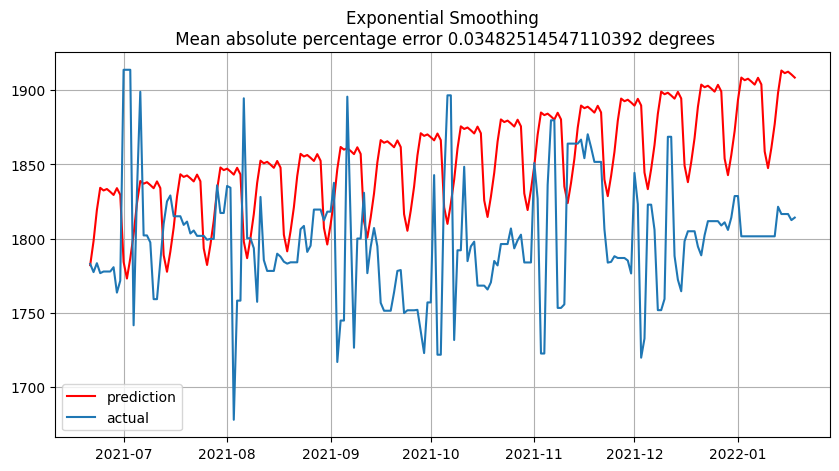

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(future_pred_holt_gold,"r", label="prediction")
plt.plot(test_data_holt_g, label="actual")
plt.grid(True)
plt.legend(loc="best")
plt.title(f"Exponential Smoothing\n Mean absolute percentage error {mean_absolute_percentage_error(future_pred_holt_gold, test_data_holt_g)} degrees");

In [ ]:
combined = np.column_stack((test_data_holt_g, future_pred_holt_gold))
gold_holt_traid = pd.DataFrame(combined, columns=['price', 'predict'])

# Задаем проценты для стоп-лосса и тейк-профита
stop_loss_percent = 0.3
take_profit_percent = 0.6


# Функция для проверки достижения стоп-лосса или тейк-профита
def check_position(data):
  forecast_price = data["predict"]
  actual_price = data["price"]

  stop_loss_price = forecast_price - (forecast_price * stop_loss_percent / 100)
  take_profit_price = forecast_price + (forecast_price * take_profit_percent / 100)

  if actual_price <= stop_loss_price:
      return "Стоп-лосс достигнут"
  elif actual_price >= take_profit_price:
      return "Тейк-профит достигнут"
  else:
      return "Позиция закрыта без достижения стоп-лосса или тейк-профита"

# Применяем функцию к каждой строке датасета и создаем новый столбец
gold_holt_traid["position"] = gold_holt_traid.apply(check_position, axis=1)

In [ ]:
value_counts_holt_gold = gold_holt_traid['position'].value_counts()
print(value_counts_holt_gold)

Стоп-лосс достигнут                                           180
Тейк-профит достигнут                                          19
Позиция закрыта без достижения стоп-лосса или тейк-профита     13
Name: position, dtype: int64


### Линейная регрессия

In [ ]:
gold_df['Цена'].shift(1)

Timestamp
2019-01-03       NaN
2019-01-04    1299.2
2019-01-05    1294.2
2019-01-06    1284.2
2019-01-07    1284.2
               ...  
2022-01-14    1821.4
2022-01-15    1816.5
2022-01-16    1816.5
2022-01-17    1816.5
2022-01-18    1812.4
Freq: D, Name: Цена, Length: 1112, dtype: float64

In [ ]:
for i in range(1,8):
  gold_df[f"lag{i}"] = gold_df['Цена'].shift(i)

In [ ]:
gold_df.head()

,Цена,lag1,lag2,lag3,lag4,lag5,lag6,lag7
Timestamp,,,,,,,,
2019-01-03,1299.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-04,1294.2,1299.2,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-05,1284.2,1294.2,1299.2,NaN,NaN,NaN,NaN,NaN
2019-01-06,1284.2,1284.2,1294.2,1299.2,NaN,NaN,NaN,NaN
2019-01-07,1389.3,1284.2,1284.2,1294.2,1299.2,NaN,NaN,NaN


In [ ]:
gold_df.dropna(inplace=True)
gold_df

,Цена,lag1,lag2,lag3,lag4,lag5,lag6,lag7
Timestamp,,,,,,,,
2019-01-10,1489.0,1432.4,1432.4,1389.3,1284.2,1284.2,1294.2,1299.2
2019-01-11,1511.4,1489.0,1432.4,1432.4,1389.3,1284.2,1284.2,1294.2
2019-01-12,1511.4,1511.4,1489.0,1432.4,1432.4,1389.3,1284.2,1284.2
2019-01-13,1511.4,1511.4,1511.4,1489.0,1432.4,1432.4,1389.3,1284.2
2019-01-14,1511.4,1511.4,1511.4,1511.4,1489.0,1432.4,1432.4,1389.3
...,...,...,...,...,...,...,...,...
2022-01-14,1816.5,1821.4,1801.5,1801.5,1801.5,1801.5,1801.5,1801.5
2022-01-15,1816.5,1816.5,1821.4,1801.5,1801.5,1801.5,1801.5,1801.5
2022-01-16,1816.5,1816.5,1816.5,1821.4,1801.5,1801.5,1801.5,1801.5


In [ ]:
train_g = gold_df.loc['01-09-2019':'02-08-2021']
test_g = gold_df.loc['03-08-2021':'02-02-2022']

train_g.shape, test_g.shape

((761, 8), (317, 8))

In [ ]:
X_train = train_g.drop('Цена', axis=1)
y_train = train_g['Цена']

X_test = test_g.drop('Цена', axis=1)
y_test = test_g['Цена']

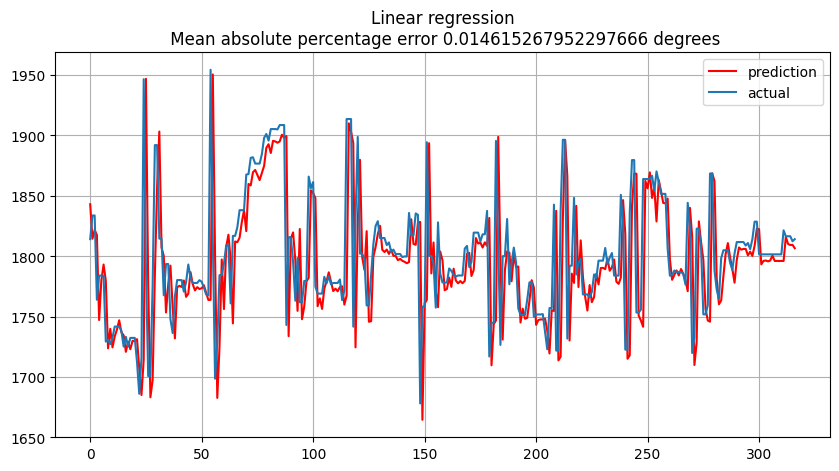

In [ ]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)

preds = lr.predict(X_test)

plt.figure(figsize=(10,5))
plt.plot(preds,"r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.grid(True)
plt.legend(loc="best")
plt.title(f"Linear regression\n Mean absolute percentage error {mean_absolute_percentage_error(preds, y_test)} degrees");

In [ ]:
combined_array = np.column_stack((y_test, preds))
gold_lin_traid = pd.DataFrame(combined_array, columns=['price', 'predict'])

In [ ]:
gold_lin_traid

,price,predict
0,1814.1,1843.024699
1,1833.7,1814.459679
2,1833.7,1821.672698
3,1763.9,1817.597173
4,1783.9,1747.095405
...,...,...
312,1816.5,1815.960638
313,1816.5,1810.111025
314,1816.5,1809.248760
315,1812.4,1809.412242


In [ ]:
# Задаем проценты для стоп-лосса и тейк-профита
stop_loss_percent = 0.3
take_profit_percent = 0.6


In [ ]:
# Функция для проверки достижения стоп-лосса или тейк-профита
def check_position(data):
  forecast_price = data["predict"]
  actual_price = data["price"]

  stop_loss_price = forecast_price - (forecast_price * stop_loss_percent / 100)
  take_profit_price = forecast_price + (forecast_price * take_profit_percent / 100)

  if actual_price <= stop_loss_price:
      return "Стоп-лосс достигнут"
  elif actual_price >= take_profit_price:
      return "Тейк-профит достигнут"
  else:
      return "Позиция закрыта без достижения стоп-лосса или тейк-профита"

# Применяем функцию к каждой строке датасета и создаем новый столбец
gold_lin_traid["position"] = gold_lin_traid.apply(check_position, axis=1)



In [ ]:
gold_lin_traid

,price,predict,position
0,1814.1,1843.024699,Стоп-лосс достигнут
1,1833.7,1814.459679,Тейк-профит достигнут
2,1833.7,1821.672698,Тейк-профит достигнут
3,1763.9,1817.597173,Стоп-лосс достигнут
4,1783.9,1747.095405,Тейк-профит достигнут
...,...,...,...
312,1816.5,1815.960638,Позиция закрыта без достижения стоп-лосса или ...
313,1816.5,1810.111025,Позиция закрыта без достижения стоп-лосса или ...
314,1816.5,1809.248760,Позиция закрыта без достижения стоп-лосса или ...
315,1812.4,1809.412242,Позиция закрыта без достижения стоп-лосса или ...


In [ ]:
value_counts = gold_lin_traid['position'].value_counts()
print(value_counts)

Позиция закрыта без достижения стоп-лосса или тейк-профита    154
Тейк-профит достигнут                                          96
Стоп-лосс достигнут                                            67
Name: position, dtype: int64


### Дерево

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [ ]:
X_train = train_g.drop('Цена', axis=1)
y_train = train_g['Цена']

X_test = test_g.drop('Цена', axis=1)
y_test = test_g['Цена']

In [ ]:
# Создание и обучение модели случайного леса
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [ ]:
# Прогнозирование на тестовом наборе
y_pred = model.predict(X_test)

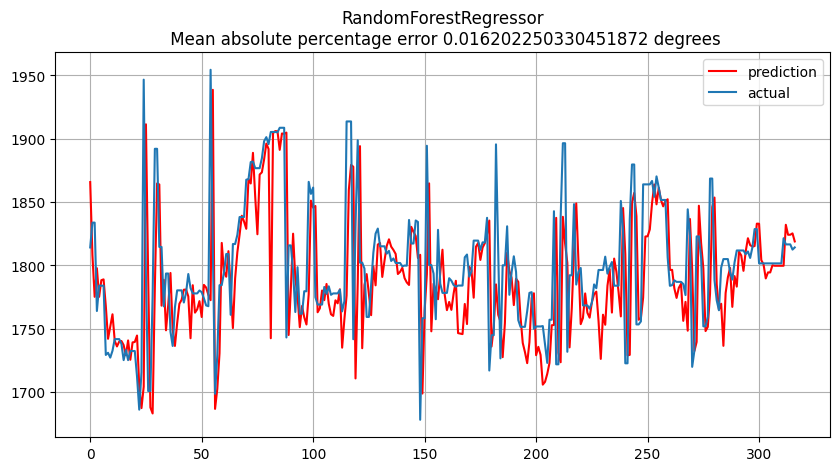

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(y_pred,"r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.grid(True)
plt.legend(loc="best")
plt.title(f"RandomForestRegressor\n Mean absolute percentage error {mean_absolute_percentage_error(y_pred, y_test)} degrees");

In [ ]:
combined_array = np.column_stack((y_test, y_pred))
gold_forest_traid = pd.DataFrame(combined_array, columns=['price', 'predict'])

In [ ]:
# Задаем проценты для стоп-лосса и тейк-профита
stop_loss_percent = 0.3
take_profit_percent = 0.6

In [ ]:
# Функция для проверки достижения стоп-лосса или тейк-профита
def check_position(data):
  forecast_price = data["predict"]
  actual_price = data["price"]

  stop_loss_price = forecast_price - (forecast_price * stop_loss_percent / 100)
  take_profit_price = forecast_price + (forecast_price * take_profit_percent / 100)

  if actual_price <= stop_loss_price:
      return "Стоп-лосс достигнут"
  elif actual_price >= take_profit_price:
      return "Тейк-профит достигнут"
  else:
      return "Позиция закрыта без достижения стоп-лосса или тейк-профита"

# Применяем функцию к каждой строке датасета и создаем новый столбец
gold_forest_traid["position"] = gold_forest_traid.apply(check_position, axis=1)

In [ ]:
gold_forest_traid

,price,predict,position
0,1814.1,1865.694,Стоп-лосс достигнут
1,1833.7,1807.994,Тейк-профит достигнут
2,1833.7,1775.105,Тейк-профит достигнут
3,1763.9,1797.710,Стоп-лосс достигнут
4,1783.9,1775.106,Позиция закрыта без достижения стоп-лосса или ...
...,...,...,...
312,1816.5,1831.980,Стоп-лосс достигнут
313,1816.5,1824.106,Стоп-лосс достигнут
314,1816.5,1824.130,Стоп-лосс достигнут
315,1812.4,1825.213,Стоп-лосс достигнут


In [ ]:
value_counts = gold_forest_traid['position'].value_counts()
print(value_counts)

Тейк-профит достигнут                                         133
Позиция закрыта без достижения стоп-лосса или тейк-профита     95
Стоп-лосс достигнут                                            89
Name: position, dtype: int64


### Сравнение результатов

In [ ]:
gold_srav = pd.DataFrame({'ARIMA': [29, 168, 15],
                   'Exponentia_Smoothing': [19, 180, 13],
                   'Linear_regression': [96, 66, 155],
                   'Random_Forest_Regressor': [151, 78,88]}, index=['Тейк-профит_достигнут', 'Стоп-лосс_достигнут', 'Дней в позиции'])
gold_srav = gold_srav.T

gold_srav = gold_srav.assign(ROI=(gold_srav['Тейк-профит_достигнут']*10).sub(gold_srav['Стоп-лосс_достигнут']*5))

In [ ]:
gold_srav

,Тейк-профит_достигнут,Стоп-лосс_достигнут,Дней в позиции,ROI
ARIMA,29,168,15,-550
Exponentia_Smoothing,19,180,13,-710
Linear_regression,96,66,155,630
Random_Forest_Regressor,151,78,88,1120
